In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from time import time

In [2]:
catfish_sales = pd.read_csv('cat_fish.csv', index_col=0, parse_dates=[0], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [4]:
catfish_sales = catfish_sales['Total']

In [5]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))
catfish_sales

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [6]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
catfish_sales = catfish_sales[start_date:end_date]

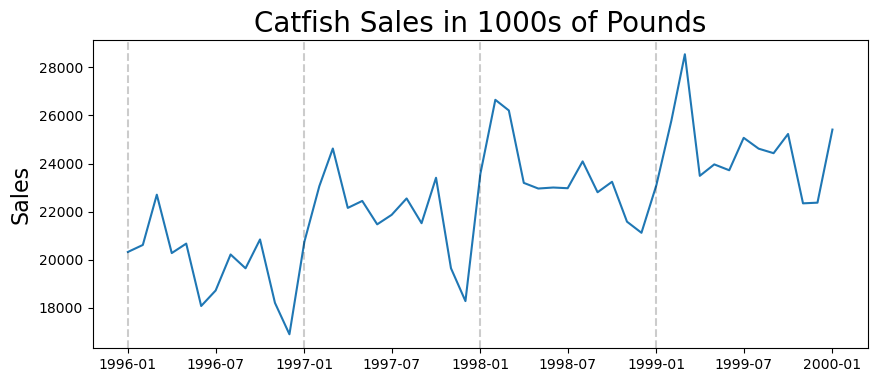

In [8]:
plt.figure(figsize=(10,4))
plt.plot(catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [10]:
first_diff = catfish_sales.diff()[1:]

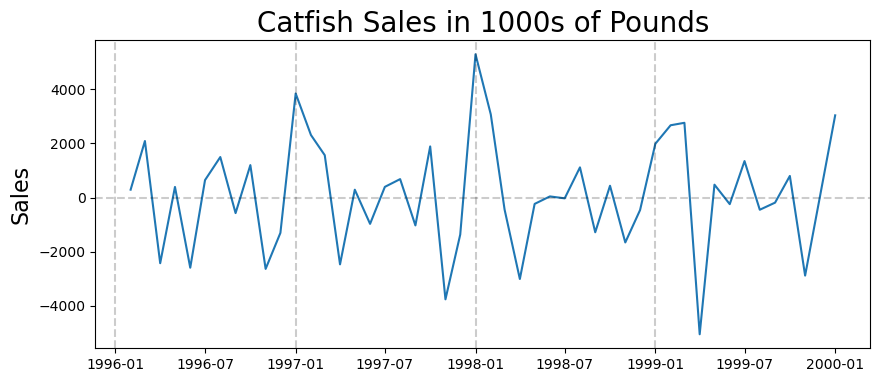

In [11]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [12]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

perform_adf_test(first_diff)

ADF Statistic: -9.515039
p-value: 0.000000


In [13]:
perform_adf_test(catfish_sales)

ADF Statistic: -2.342716
p-value: 0.158561


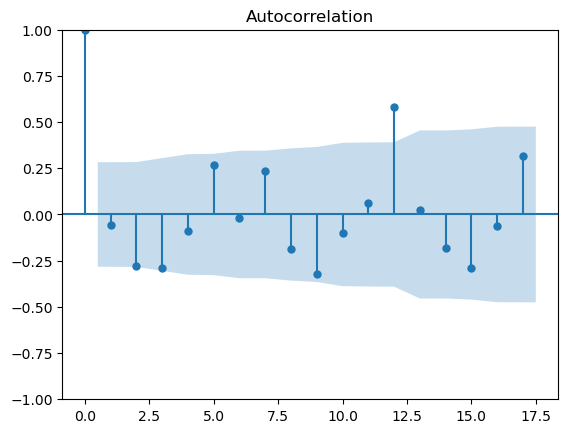

In [14]:
acf_plot = plot_acf(first_diff)

c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


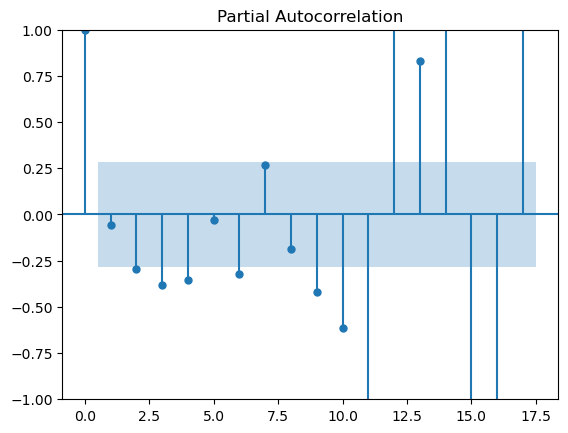

In [18]:
pacf_plot = plot_pacf(first_diff)

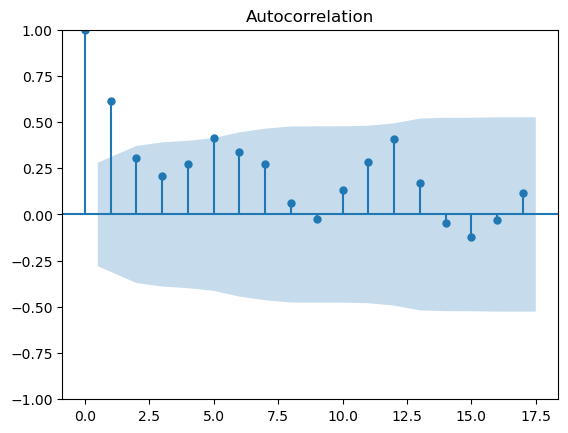

In [19]:
acf_plot = plot_acf(catfish_sales)

c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


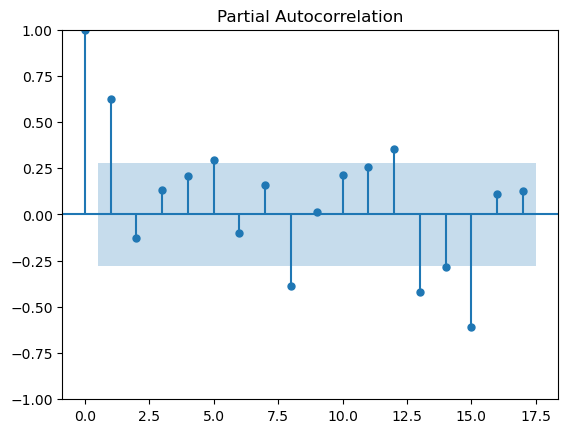

In [20]:
pacf_plot = plot_pacf(catfish_sales)

In [16]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = catfish_sales[:train_end]
test_data = catfish_sales[train_end + timedelta(days=1):test_end]

In [17]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [21]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model Fitting Time: 4.055519104003906


In [22]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Sun, 05 Feb 2023   AIC                            737.269
Time:                                      15:55:21   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8251      0.120      6.849      0.000       0.589       1.061
ma.S.L12      -0.51

In [23]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions

1999-08-01    25695.496970
1999-09-01    25054.199246
1999-10-01    25642.902168
1999-11-01    24195.574851
1999-12-01    23677.294476
2000-01-01    26250.759600
Freq: MS, Name: predicted_mean, dtype: float64

In [24]:
predictions = pd.Series(predictions, index=test_data.index)
predictions

Date
1999-08-01    25695.496970
1999-09-01    25054.199246
1999-10-01    25642.902168
1999-11-01    24195.574851
1999-12-01    23677.294476
2000-01-01    26250.759600
Freq: MS, Name: predicted_mean, dtype: float64

In [25]:
residuals = test_data - predictions

Text(0, 0.5, 'Error')

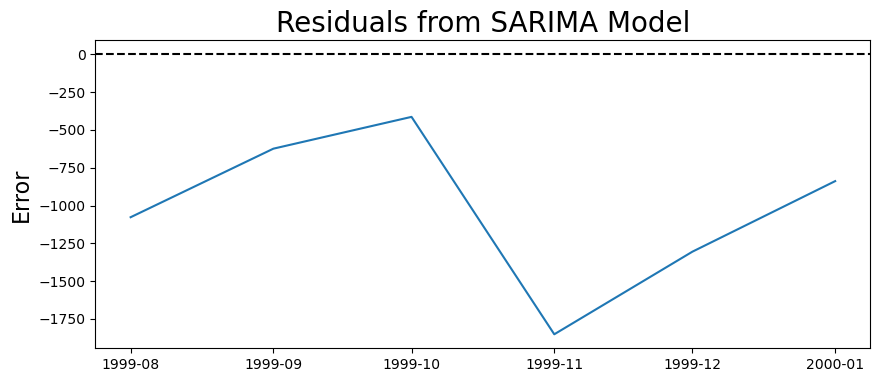

In [26]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

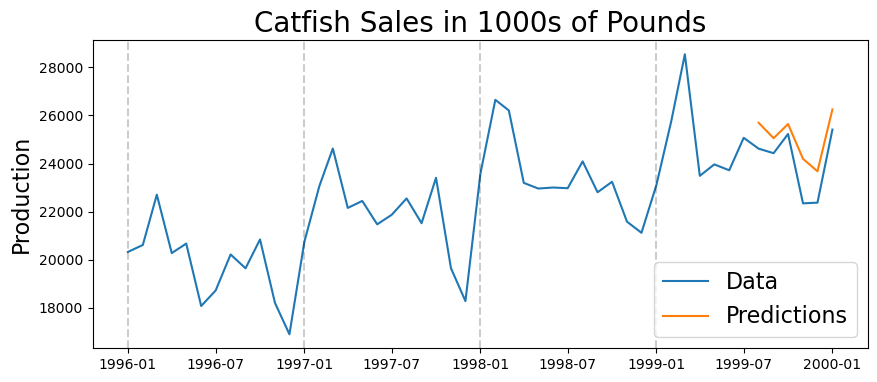

In [27]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [28]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [29]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3175567869423


In [30]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\equipo\miniconda3\envs\development\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-station

In [31]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

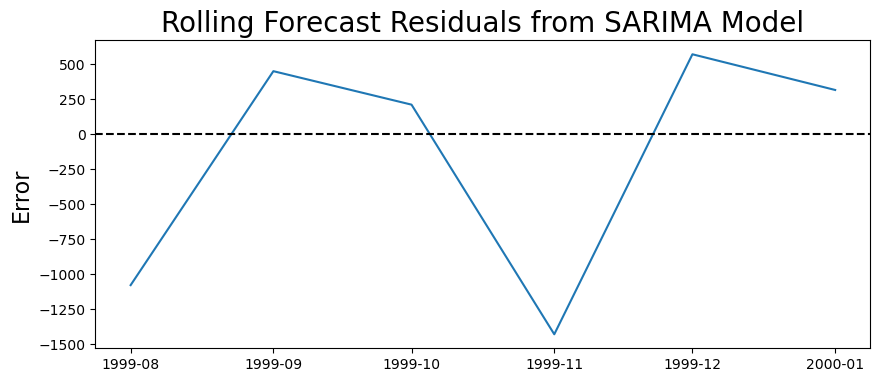

In [32]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

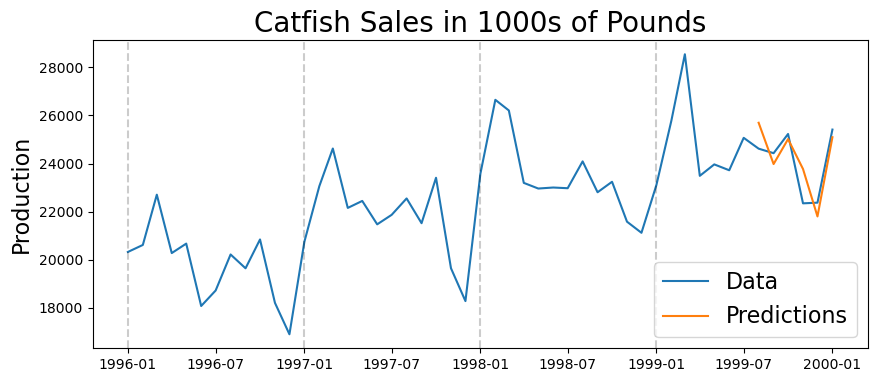

In [33]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0288


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 804.1404775210653
